# Turkish Movie adlı verisetine Duygu Analizi Uygulanması

## 1. Veri Yüklenmesi ve Ön işleme

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import re

In [2]:
df = pd.read_csv('turkish_movie_sentiment_dataset.csv', decimal=",")

In [3]:
count = pd.DataFrame(df.point.value_counts()).sort_index(ascending=False)
count.columns = ['count']
fig = px.pie(count, values='count', names=count.index, title='Distribution of points', width=800, height=500)
fig.show()

Verisetinde de görüldüğü üzere yorumların değerlendirilmesi point sütununda yapılmıştır. 

*   Point değeri 2.5 olan yorumlar nötr sayılabileceği için veri setinden atılmıştır. 
*   Point değeri 2.5'tan büyük ise 'positive' yani 1
*   Ortalama puan 2.5'ten küçük ise 'negative' yani -1

olarak değerlendirilecektir. Böylelikle modelin duygu analizi için 'label' olarak kullanabileceği verilere ulaşmış olacağız.

In [4]:
df['sentiment'] = (df.apply(lambda x: 0 if (2.5>=x.point) else 1, axis=1))
df.drop(df.loc[df['point']==2.5].index, inplace=True)
df

,comment,film_name,point,sentiment
0,\n Jean Reno denince zate...,Sevginin Gücü,5.0,1
1,\n Ekşın falan izlemek is...,Sevginin Gücü,5.0,1
2,\n Bu yapım hakkında öyle...,Sevginin Gücü,5.0,1
3,\n finali yeter... (sting...,Sevginin Gücü,5.0,1
4,\n Jean Reno..\r\nbu adam...,Sevginin Gücü,5.0,1
...,...,...,...,...
83219,\n Filmi dün izledim .Her...,Kabus,1.0,0
83220,\n Zaten konusunu bile ok...,Kabus,3.0,1
83224,\n bugün dvd'sini alıp iz...,Kabus,1.0,0
83225,\n Klasik korku ve gerili...,Kabus,4.0,1


### 1.1 Verinin Seçilmesi

Verilerde negatif ve nötr yorumlara oranla çok fazla pozitif veri bulunmaktadır. Bu da veriyi dengesiz hale getirmektedir. Dengesizliği düzeltmek için **under-sampling** tekniğinin uygulanması tercih edilmiştir.

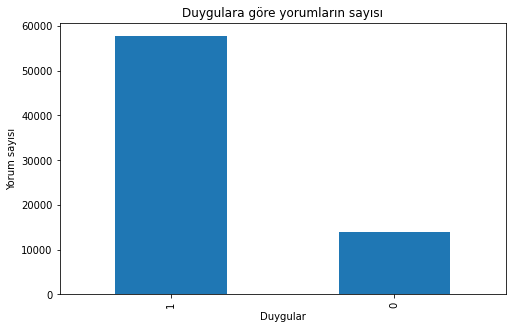

In [5]:
df['sentiment'].value_counts().plot(kind='bar', figsize = (8,5), ylabel='Yorum sayısı', xlabel='Duygular', title='Duygulara göre yorumların sayısı')
plt.show()

In [6]:
print("Negatif örnek sayısı {}.".format(len(df[df['sentiment']==0])))

Negatif örnek sayısı 13964.


In [7]:
positive_data = df[df['sentiment'] == 1].sample(n=14000, random_state=42)

In [8]:
df = pd.concat([positive_data, df[df['sentiment']==0]], axis=0)

Negatif ve pozitif yorumların sayısı dengelenmiştir.

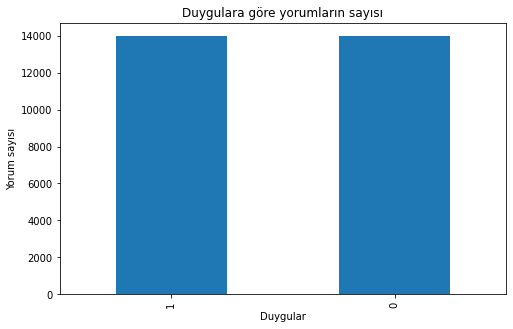

In [9]:
df['sentiment'].value_counts().plot(kind='bar', figsize = (8,5), ylabel='Yorum sayısı', xlabel='Duygular', title='Duygulara göre yorumların sayısı')
plt.show()

### 1.2 Verinin Temizlenmesi



KISIM 1: Emojilerin kaldırılması

Veri metin halinde emojiler içermektedir. Emojilerin belirttiği duygu yerine pozitif, negatif kelimeleri yerleştirilir.

In [10]:
df.comment.replace(r'(?::\)|:-\)|=\)|:D|:d|<3|\(:|:\'\)|\^\^|;\)|\(-:)', 'pozitifemoji', regex=True, inplace=True)
df.comment.replace(r'(:-\(|:\(|;\(|;-\(|=\(|:/|:\\|-_-|\):|\)-:)', 'negatifemoji', regex=True, inplace=True)

KISIM 2: Noktalama işaretleri ve sayısal değerlerin kaldırılması

Review kısmındaki verileri modelde kullanmadan önce NLP prensiplerine göre bir takım işlemlerden geçirmek gerekiyor, bu bağlamda öncelikle verilerdeki noktalama işaretleri ve büyük-küçük harflerden doğacak problemlerin önünü kesmek adına *prepare_data* adında bir fonksiyon tanımladık.

In [11]:
def prepare_data(text):
    text = re.sub("İ","i",text)
    text = re.sub('[^\w\s]','',text)
    text = re.sub('\d+', '', text)
    text = re.sub('\n',' ', text)
    text = re.sub('\r',' ', text)
    text = text.lower()
    return text

In [12]:
df['comment'] = df.apply(lambda row : prepare_data(str(row['comment'])), axis = 1)

KISIM 3: Tekrar eden harflerin kaldırılması

Örneğin süpeeer şeklinde yazılmış kelimenin diğer süper kelimesi ile ilişki kurabilmesi süper şekline dönüştürülmesi gerekmektedir.

In [13]:
def remove_repeating_char(word):
    new_word = " "
    prev_char = ' '
    for char in word:
    	if prev_char == char:
    		continue
    	new_word = new_word + char
    	prev_char = char
    return new_word

In [14]:
df["comment"] = df["comment"].apply(lambda text: remove_repeating_char(str(text)))

KISIM 4: Belirli bir uzunluğun üstündeki kelimelerin kaldırılması

In [15]:
def remove_n_length_words(text, length):
  return ' '.join([w for w in str(text).split() if len(w)<length])

In [16]:
df["comment"] = df["comment"].apply(lambda text: remove_n_length_words(text, 15))

KISIM 5: Stopword (Bağlaç) Temizlenmesi

In [17]:
def remove_words(text, remove_words):
  return " ".join([word for word in str(text).split() if word not in remove_words])

In [18]:
def replace_turkish_char(word):
	word = word.replace('ş','s')
	word = word.replace('ç','c')
	word = word.replace('ğ','g')
	word = word.replace('ü','u')
	word = word.replace('ö','o')
	word = word.replace('ı','i')
	return word

In [19]:
df["comment"] = df["comment"].apply(lambda text: replace_turkish_char(str(text)))

In [20]:
!pip install nltk
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
STOPWORDS = stopwords.words("turkish")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [21]:
STOPWORDS.extend(["bir", "iki", "üç", "bi", "ben", "bence", "benden", "beni", "bile", "böylece", "çok", "herşey", "için", "ilk", "kadar", "şey", "yine", "zaten"])

In [22]:
STOPWORDS += [replace_turkish_char(word) for word in STOPWORDS]

In [23]:
df["comment"] = df["comment"].apply(lambda text: remove_words(text, STOPWORDS))

KISIM 6: En az kullanılan kelimelerin kaldırılması

In [24]:
from collections import Counter
cnt = Counter()
for text in df["comment"].values:
  for word in text.split():
    cnt[word] += 1

In [25]:
rare_word_number = 100
rare_words = set([w for (w, wc) in cnt.most_common()[:-rare_word_number-1:-1]])

In [26]:
df["comment"] = df["comment"].apply(lambda text: remove_words(text, rare_words))

In [27]:
#Bazı yorumlar yukarıdaki işlemler sonucu boş kalmışlardır. Bu yorumları içeren satırların silinmesi gerekir.
df.comment = df.comment.replace(r'^\s*$', np.nan, regex=True)
df = df[df['comment'].notna()]

In [28]:
most_common = pd.DataFrame(cnt.most_common(20))
most_common.columns = ['word', 'count']
fig = px.bar(most_common, x='word', y='count', color='word', title='Most common 20 words', width=800, height=500)
fig.update_layout(showlegend=False)
fig.show()

### 2. Eğitim ve test verisini hazırlamak

In [29]:
x = df['comment']
y = df['sentiment'].values.reshape(-1,1)

In [30]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.3, random_state = 42)

# Tokenizer'ın doğru çalışabilmesi için train ve test verilerini array'e çevirmek gerekiyor
x_train = np.array(x_train.values.tolist())
x_test = np.array(x_test.values.tolist())

#### 2.1 Makine Öğrenmesi Metotlarının Kullanılması

Model ismi: RandomForestClassifier
Accuracy: 0.7930204572803851


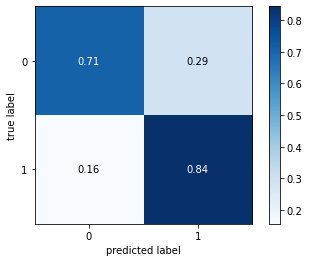



Classification Report

              precision    recall  f1-score   support

           0       0.82      0.71      0.76      4147
           1       0.75      0.84      0.79      4169

    accuracy                           0.78      8316
   macro avg       0.78      0.78      0.78      8316
weighted avg       0.78      0.78      0.78      8316

Model ismi: LinearSVC
Accuracy: 0.8315282791817088


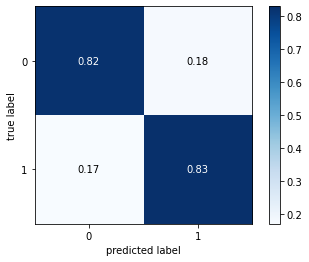



Classification Report

              precision    recall  f1-score   support

           0       0.83      0.82      0.82      4147
           1       0.82      0.83      0.83      4169

    accuracy                           0.83      8316
   macro avg       0.83      0.83      0.83      8316
weighted avg       0.83      0.83      0.83      8316

Model ismi: BernoulliNB
Accuracy: 0.7980769230769231


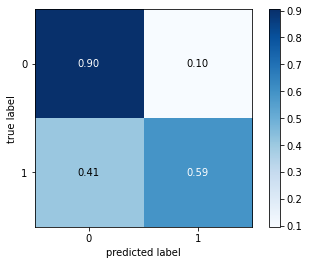



Classification Report

              precision    recall  f1-score   support

           0       0.69      0.90      0.78      4147
           1       0.86      0.59      0.70      4169

    accuracy                           0.75      8316
   macro avg       0.78      0.75      0.74      8316
weighted avg       0.78      0.75      0.74      8316



In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

#Makine ögrenimi metodlarında kullancağımız veriyi vektörize ediyoruz
model_vectorizer = TfidfVectorizer()
tfidf_train = model_vectorizer.fit_transform(x_train)
tfidf_test = model_vectorizer.transform(x_test)

#3 adet makine öğrenmesi yöntemi seçiyoruz, bunlar üzerinde denemeler yapıp karşılaştırmalarda bulunacağız
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    BernoulliNB()
]

fpr_values = []
tpr_values = []
for model in models:

  model_name = model.__class__.__name__
  print("Model ismi:", model_name)
  mlmodel = model
  mlmodel.fit(tfidf_train, y_train.ravel())

  # ACC score
  best_accuracy = cross_val_score(mlmodel, tfidf_test, y_test.ravel(), cv=10, scoring='accuracy').max()
  print("Accuracy:",best_accuracy)

  y_pred = mlmodel.predict(tfidf_test)
  # Confusion Matrix'i özel bir görselleştirme metoduyla çağırıyoruz (mlextend kütüphanesinden)
  figure, ax = plot_confusion_matrix(conf_mat = confusion_matrix(y_test, y_pred),
                                   show_absolute = False,
                                   show_normed = True,
                                   colorbar = True)
    
  plt.show()
  
  fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
  fpr_values.append(fpr)
  tpr_values.append(tpr)

  # Sınıflandırma Raporu
  cr = classification_report(y_test, y_pred)
  print("\n\nClassification Report\n")
  print(cr)



#### 2.2 Derin Öğrenme Modelinin Kurulması

In [32]:
from keras_preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)
word_idx = tokenizer.word_index
size = len(word_idx)+1
print("Verisetinden alınan toplam sample sayısı: ", size)

#text to sequences
x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

Verisetinden alınan toplam sample sayısı:  93521


In [33]:
#Reviewların aynı boyutta olmasını garanti altına almak gerek, aksi halde model oluşturulurken sorun çıkabilir
from tensorflow.keras.preprocessing.sequence import pad_sequences
fixed_length = 60
x_train = pad_sequences(x_train, padding='post', maxlen=fixed_length)
x_test = pad_sequences(x_test, padding='post', maxlen=fixed_length)

In [34]:
from tensorflow.keras.layers import LSTM, Dense, Embedding, Bidirectional
from tensorflow.keras.models import Sequential
from keras import optimizers
  
adam = optimizers.Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.99, decay=0)
model = Sequential()
model.add(Embedding(size, 8, input_length = fixed_length))
model.add(Bidirectional(LSTM(16, return_sequences=True, dropout=1e-4)))
model.add(Bidirectional(LSTM(16, return_sequences=False, dropout=1e-3)))
model.add(Dense(1, activation = "sigmoid"))
model.compile(optimizer=adam, loss='binary_crossentropy',metrics=['acc'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 60, 8)             748168    
_________________________________________________________________
bidirectional (Bidirectional (None, 60, 32)            3200      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 32)                6272      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 757,673
Trainable params: 757,673
Non-trainable params: 0
_________________________________________________________________
None


In [35]:
history = model.fit(x_train,y_train,batch_size=128,epochs=5,verbose=1,validation_data=(x_test,y_test))

Epoch 1/5
152/152 [==============================] - 32s 153ms/step - loss: 0.6929 - acc: 0.5366 - val_loss: 0.6923 - val_acc: 0.5964
Epoch 2/5
152/152 [==============================] - 20s 133ms/step - loss: 0.6902 - acc: 0.6414 - val_loss: 0.6869 - val_acc: 0.6675
Epoch 3/5
152/152 [==============================] - 20s 132ms/step - loss: 0.6606 - acc: 0.6712 - val_loss: 0.6112 - val_acc: 0.6722
Epoch 4/5
152/152 [==============================] - 20s 130ms/step - loss: 0.4998 - acc: 0.8223 - val_loss: 0.4888 - val_acc: 0.7929
Epoch 5/5
152/152 [==============================] - 21s 140ms/step - loss: 0.4009 - acc: 0.8544 - val_loss: 0.4413 - val_acc: 0.8098


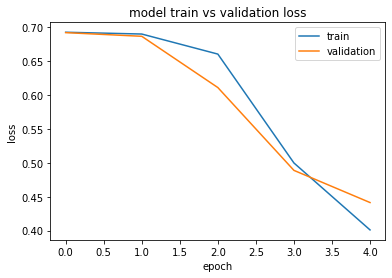

In [36]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

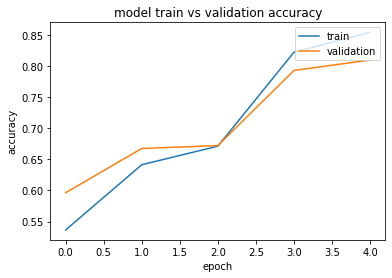

In [37]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model train vs validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [38]:
y_pred = model.predict(x_test)

In [39]:
  fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
  fpr_values.append(fpr)
  tpr_values.append(tpr)

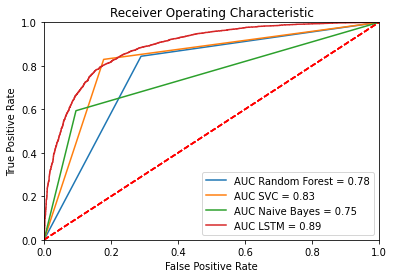

In [40]:
label = ['Random Forest', 'SVC', 'Naive Bayes', 'LSTM']
for i in range(4):
    fpr = fpr_values[i]
    tpr = tpr_values[i]
    roc_auc = metrics.auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, label = ('AUC {} = %0.2f' % roc_auc).format(label[i]))
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')

### 3. Yeni yorumlardan duygu analizinin yapılması

In [41]:
def predict_sentiment(text):
  text = tokenizer.texts_to_sequences([text])
  padded = pad_sequences(text, maxlen=fixed_length)
  res = model.predict(padded, batch_size=1)
  if res < 0.5:
    print("Negatif Yorum")
  else: 
    print("Pozitif Yorum")
  return res

In [42]:
text = 'Senaryo çok zayıftı ve filmi izlerken çok sıkıldım.'
text = remove_words(text, STOPWORDS)
text = replace_turkish_char(text)
predict_sentiment(text)

Negatif Yorum


array([[0.24919888]], dtype=float32)

In [43]:
text = 'Baya iyiydi çok sevdim.'
text = remove_words(text, STOPWORDS)
text = replace_turkish_char(text)
predict_sentiment(text)

Pozitif Yorum


array([[0.8268376]], dtype=float32)

In [44]:
text = 'Oyuncular ve senaryo şahaneydi filmi tekrar tekrar izleyesim geldi. Herkese öneriyorum kesinlikle izlemelisiniz.'
text = remove_words(text, STOPWORDS)
text = replace_turkish_char(text)
predict_sentiment(text)

Pozitif Yorum


array([[0.8313397]], dtype=float32)

In [45]:
text = 'Berbat'
text = remove_words(text, STOPWORDS)
text = replace_turkish_char(text)
predict_sentiment(text)

Negatif Yorum


array([[0.25302058]], dtype=float32)

In [46]:
text = 'İyi değildi.'
text = remove_words(text, STOPWORDS)
text = replace_turkish_char(text)
predict_sentiment(text)

Negatif Yorum


array([[0.32941526]], dtype=float32)

In [47]:
text = 'Başarılı bir filmdi ve oldukça başarılı senaryosu vardı.'
text = remove_words(text, STOPWORDS)
text = replace_turkish_char(text)
predict_sentiment(text)

Pozitif Yorum


array([[0.8405728]], dtype=float32)

In [48]:
text = 'Oldukça başarılı senaryosu vardı.'
text = remove_words(text, STOPWORDS)
text = replace_turkish_char(text)
predict_sentiment(text)

Pozitif Yorum


array([[0.83543116]], dtype=float32)

In [49]:
y_pred = [0 if pred < 0.5 else 1 for pred in y_pred]

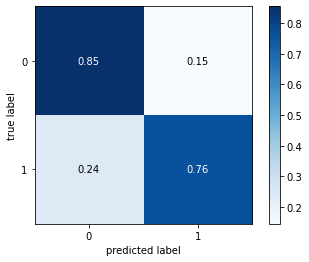

In [50]:
cm = metrics.confusion_matrix(y_test, y_pred)

figure, ax = plot_confusion_matrix(conf_mat = cm,
                                   show_absolute = False,
                                   show_normed = True,
                                   colorbar = True)

plt.show()

In [51]:
cr = classification_report(y_test, y_pred)
print("\n\nClassification Report\n")
print(cr)



Classification Report

              precision    recall  f1-score   support

           0       0.78      0.85      0.82      4147
           1       0.84      0.76      0.80      4169

    accuracy                           0.81      8316
   macro avg       0.81      0.81      0.81      8316
weighted avg       0.81      0.81      0.81      8316

